In [1]:
# Importing necessary libraries
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer
from transformers import SegformerFeatureExtractor
from sklearn.model_selection import train_test_split
import albumentations as A
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

bin C:\Users\skoka3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\bitsandbytes\libbitsandbytes_cuda113.dll


In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [3]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from transformers import SegformerFeatureExtractor
from transformers import AutoModelForSemanticSegmentation

import albumentations as A

def load_mask(mask_path, num_classes):
    # Load the mask image
    mask_image = Image.open(mask_path)
    
    # Convert mask image to numpy array
    mask_array = np.array(mask_image)
    
    # If mask is RGB, convert it to a unique class map
    if len(mask_array.shape) == 3:  # RGB image
        # Convert RGB to a unique number (assuming 8-bit per channel)
        mask = mask_array[:, :, 0] * 256 * 256 + mask_array[:, :, 1] * 256 + mask_array[:, :, 2]
        
        # Map unique RGB combinations to class indices
        unique_colors = np.unique(mask)
        color_to_class = {color: idx for idx, color in enumerate(unique_colors)}
        mask_class_map = np.vectorize(color_to_class.get)(mask)
        
        # Clip to number of classes
        mask_class_map = np.clip(mask_class_map, 0, num_classes - 1)
        
        return mask_class_map
    else:
        # If mask is already in single channel format, just return it
        return mask_array

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_names, feature_extractor, num_classes, augmentation=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_names = [name for name in img_names if name.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.feature_extractor = feature_extractor
        self.num_classes = num_classes
        self.augmentation = augmentation

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        mask_path = os.path.join(self.mask_dir, self.img_names[idx].replace('.jpg', '.png'))
        image = Image.open(img_path).convert("RGB")
        
        mask = load_mask(mask_path, self.num_classes)
        
        # Apply resizing
        resize_transform = A.Compose([A.Resize(64, 64)])
        augmented = resize_transform(image=np.array(image), mask=mask)
        image, mask = augmented['image'], augmented['mask']

        # Apply additional augmentations
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Process image with feature extractor
        encoded_inputs = self.feature_extractor(images=image, return_tensors="pt")
        encoded_inputs['labels'] = torch.tensor(mask, dtype=torch.long).unsqueeze(0)

        # Remove the batch dimension added by the feature extractor
        for k, v in encoded_inputs.items():
            encoded_inputs[k] = v.squeeze(0)

        return encoded_inputs



In [4]:
# Define augmentations
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # Add more transformations as needed
    ]
    return A.Compose(train_transform)

In [5]:
# Load the model and feature extractor
checkpoint = "nvidia/mit-b0"
feature_extractor = SegformerFeatureExtractor.from_pretrained(checkpoint)
model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint)

C:\Users\skoka3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\skoka3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\models\segformer\image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head

In [6]:
# Assuming you have directories with images and masks for training
image_dir = "data\imageDamage\imageDamage"
mask_dir = "data\imageDamage\FineDamageReducedPNG"


In [7]:
img_names = os.listdir(image_dir)
train_val_img_names, test_img_names = train_test_split(img_names, test_size=0.15, random_state=42)
train_img_names, valid_img_names = train_test_split(train_val_img_names, test_size=0.15, random_state=42)


In [8]:
train_img_names = train_img_names[:10]
valid_img_names = valid_img_names[:2]

In [9]:
train_img_names

['07_RCB0019_F03_DSC_0380020.jpg',
 '02_RCB0031_F01_DSC_0217015.jpg',
 '09_DJI-0002 2_image85062.jpg',
 '09_DJI-0002 2_image45022.jpg',
 '09_DJI-0002 2_image116093.jpg',
 '03_RCB0002_F05_DSC_0836000.jpg',
 '09_DJI-0002 2_image79056.jpg',
 '10_DJI-0004_image41032.jpg',
 '02_RCB0029_F01_DSC_0334004.jpg',
 '09_DJI-0002 2_image54031.jpg']

In [10]:
# Create the datasets
train_dataset = CustomImageDataset(
    img_dir=image_dir,
    mask_dir=mask_dir,
    img_names=train_img_names,
    feature_extractor=feature_extractor,
    augmentation = get_training_augmentation(),
    num_classes=7
)

valid_dataset = CustomImageDataset(
    img_dir=image_dir,
    mask_dir=mask_dir,
    img_names=valid_img_names,
    feature_extractor=feature_extractor,
    num_classes=7
)


In [11]:
# from datasets import load_metric
# mean_iou = load_metric("./metrics/mean_iou")

# results = mean_iou.compute(
#     predictions=predicted, references=ground_truth, num_labels=10, ignore_index=255, reduce_labels=False
# )
# print(results)

In [12]:
# import numpy as np
# from sklearn.metrics import confusion_matrix
# from transformers import EvalPrediction

# def compute_mIOU(preds: EvalPrediction):
#     # preds.predictions are logits, so we take the argmax to get predicted labels
#     pred_labels = np.argmax(preds.predictions, axis=1) if preds.predictions.ndim > 1 else preds.predictions
#     true_labels = preds.label_ids

#     num_classes = np.max(true_labels) + 1  # Assuming classes are zero-indexed
    
#     # Flatten the arrays
#     pred_labels = pred_labels.flatten()
#     true_labels = true_labels.flatten()

#     # Compute the confusion matrix
#     confusion = confusion_matrix(true_labels, pred_labels, labels=range(num_classes))

#     # Calculate IoU for each class
#     iou = np.diag(confusion) / (confusion.sum(axis=1) + confusion.sum(axis=0) - np.diag(confusion))

#     # Handle the case where a division by zero occurs
#     iou = np.where(np.isnan(iou), 0, iou)

#     # Compute mIoU
#     mIoU = np.nanmean(iou)

#     return {"mIoU": mIoU}

In [23]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="segformer-b0-scene-parse-150",
    learning_rate=2e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # Use your custom metric function here
    logging_steps=10,
    save_steps=0,
    training_loss = 
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    # compute_metrics=compute_mIOU
    # preds = model.eval()
    # tokenizer argument removed
)

# Train the model
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 6.678332328796387, 'eval_runtime': 0.2624, 'eval_samples_per_second': 7.621, 'eval_steps_per_second': 3.81, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 6.359519958496094, 'eval_runtime': 0.259, 'eval_samples_per_second': 7.722, 'eval_steps_per_second': 3.861, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 5.7888264656066895, 'eval_runtime': 0.2601, 'eval_samples_per_second': 7.689, 'eval_steps_per_second': 3.845, 'epoch': 3.0}
{'loss': 6.5014, 'learning_rate': 6.666666666666667e-05, 'epoch': 3.33}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 5.738979816436768, 'eval_runtime': 0.2634, 'eval_samples_per_second': 7.592, 'eval_steps_per_second': 3.796, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 5.799191951751709, 'eval_runtime': 0.2664, 'eval_samples_per_second': 7.506, 'eval_steps_per_second': 3.753, 'epoch': 5.0}
{'train_runtime': 22.7717, 'train_samples_per_second': 2.196, 'train_steps_per_second': 0.659, 'train_loss': 6.422257868448893, 'epoch': 5.0}


TrainOutput(global_step=15, training_loss=6.422257868448893, metrics={'train_runtime': 22.7717, 'train_samples_per_second': 2.196, 'train_steps_per_second': 0.659, 'train_loss': 6.422257868448893, 'epoch': 5.0})

In [24]:
model.save_pretrained("best_segformer_test")


In [25]:
training_logs = trainer.state.log_history

In [26]:
training_logs

[{'eval_loss': 6.678332328796387,
  'eval_runtime': 0.2624,
  'eval_samples_per_second': 7.621,
  'eval_steps_per_second': 3.81,
  'epoch': 1.0,
  'step': 3},
 {'eval_loss': 6.359519958496094,
  'eval_runtime': 0.259,
  'eval_samples_per_second': 7.722,
  'eval_steps_per_second': 3.861,
  'epoch': 2.0,
  'step': 6},
 {'eval_loss': 5.7888264656066895,
  'eval_runtime': 0.2601,
  'eval_samples_per_second': 7.689,
  'eval_steps_per_second': 3.845,
  'epoch': 3.0,
  'step': 9},
 {'loss': 6.5014,
  'learning_rate': 6.666666666666667e-05,
  'epoch': 3.33,
  'step': 10},
 {'eval_loss': 5.738979816436768,
  'eval_runtime': 0.2634,
  'eval_samples_per_second': 7.592,
  'eval_steps_per_second': 3.796,
  'epoch': 4.0,
  'step': 12},
 {'eval_loss': 5.799191951751709,
  'eval_runtime': 0.2664,
  'eval_samples_per_second': 7.506,
  'eval_steps_per_second': 3.753,
  'epoch': 5.0,
  'step': 15},
 {'train_runtime': 22.7717,
  'train_samples_per_second': 2.196,
  'train_steps_per_second': 0.659,
  'tota

In [27]:
training_logs

[{'eval_loss': 6.678332328796387,
  'eval_runtime': 0.2624,
  'eval_samples_per_second': 7.621,
  'eval_steps_per_second': 3.81,
  'epoch': 1.0,
  'step': 3},
 {'eval_loss': 6.359519958496094,
  'eval_runtime': 0.259,
  'eval_samples_per_second': 7.722,
  'eval_steps_per_second': 3.861,
  'epoch': 2.0,
  'step': 6},
 {'eval_loss': 5.7888264656066895,
  'eval_runtime': 0.2601,
  'eval_samples_per_second': 7.689,
  'eval_steps_per_second': 3.845,
  'epoch': 3.0,
  'step': 9},
 {'loss': 6.5014,
  'learning_rate': 6.666666666666667e-05,
  'epoch': 3.33,
  'step': 10},
 {'eval_loss': 5.738979816436768,
  'eval_runtime': 0.2634,
  'eval_samples_per_second': 7.592,
  'eval_steps_per_second': 3.796,
  'epoch': 4.0,
  'step': 12},
 {'eval_loss': 5.799191951751709,
  'eval_runtime': 0.2664,
  'eval_samples_per_second': 7.506,
  'eval_steps_per_second': 3.753,
  'epoch': 5.0,
  'step': 15},
 {'train_runtime': 22.7717,
  'train_samples_per_second': 2.196,
  'train_steps_per_second': 0.659,
  'tota

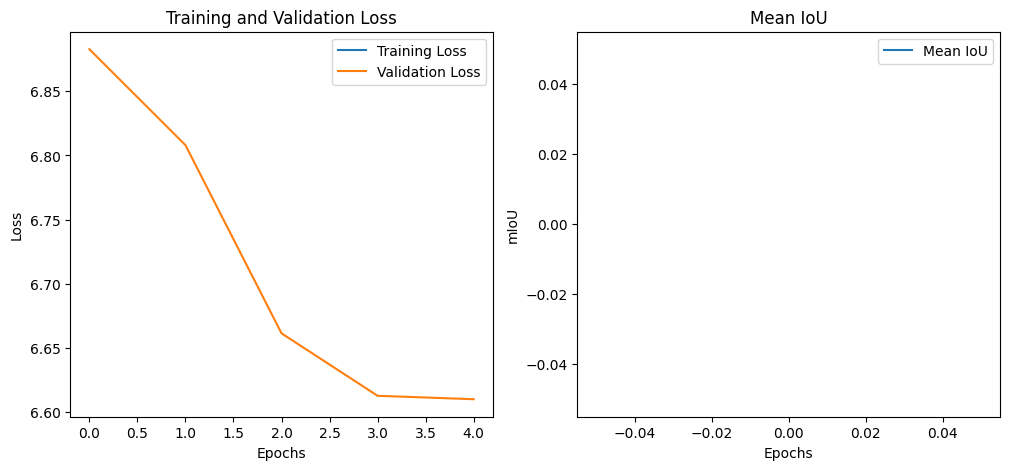

In [21]:
import matplotlib.pyplot as plt

training_logs = trainer.state.log_history

training_loss = [log['train_loss'] for log in training_logs if 'train_loss' in log]
validation_loss = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
miou = [log['eval_miou'] for log in training_logs if 'eval_miou' in log]  # Replace 'eval_miou' with your actual IoU metric name


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(training_loss)), training_loss, label='Training Loss')
plt.plot(range(len(validation_loss)), validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(miou)), miou, label='Mean IoU')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.legend()

plt.show()



In [18]:
# seg_model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint)
# Load the model
seg_model = AutoModelForSemanticSegmentation.from_pretrained("best_segformer_test")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels in the mask: {0: 'Background', 2: 'Class 2', 3: 'Unknown'}


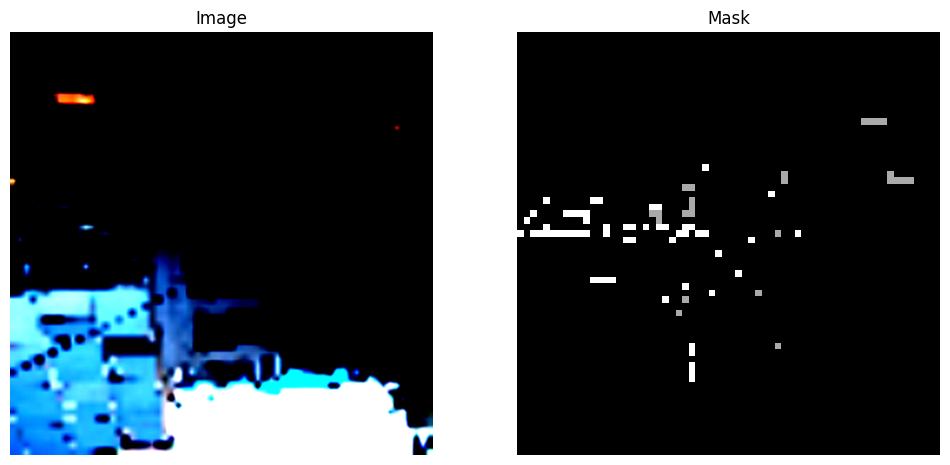

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Define paths and other necessary variables
image_dir = image_dir  # specify the path to your image directory
mask_dir = mask_dir   # specify the path to your mask directory
img_names = test_img_names  # replace with your list of image names

# Instantiate your dataset
dataset = CustomImageDataset(
    img_dir=image_dir,
    mask_dir=mask_dir,
    img_names=img_names,
    feature_extractor=feature_extractor,
    augmentation=get_training_augmentation(),
    num_classes=7
)

# Fetch an image and its mask (change index to view different images)
data = dataset[0]
image = data['pixel_values'].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and adjust dimensions
mask = data['labels'].numpy()  # Convert mask tensor to numpy array

# Create a function to visualize the image and mask
def visualize_image_and_mask(image, mask, labels=None):
    plt.figure(figsize=(12, 6))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Display the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')  # Use grayscale colormap
    plt.title('Mask')
    plt.axis('off')

    # Display labels if provided
    if labels:
        unique_labels = np.unique(mask)
        labeled_masks = {label: labels.get(label, 'Unknown') for label in unique_labels}
        print("Labels in the mask:", labeled_masks)

    plt.show()

# Define your class labels (if available)
labels_dict = {
    0: 'Background',
    1: 'Class 1',
    2: 'Class 2',
    # Add additional labels for your classes
}

# Visualize the image and its mask
visualize_image_and_mask(image, mask, labels=labels_dict)
